In [1]:
import jax
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

from rebayes_mini import callbacks
from rebayes_mini.methods import gauss_filter as gf
from rebayes_mini.methods import robust_filter as rfilter
from rebayes_mini.methods import generalised_bayes_filter as gbfilter

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [117]:
def f(x):
    return x / 5 - 10 * jnp.cos(x) * jnp.sin(x) + x ** 3


def sample_observations_grid(key, f, n_obs, xmin, xmax, x_noise=0.1, y_noise=3.0):
    key_x, key_y, key_shuffle, key_corrupted = jax.random.split(key, 4)
    
    key_cchoice, key_cval = jax.random.split(key_corrupted)
    is_corrupted = jax.random.bernoulli(key_cchoice, p=0.05, shape=(n_obs,))
    xcorr, ycorr = jax.random.uniform(key_cval, (2, n_obs))
    
    xcorr = -3 + xcorr * 6
    ycorr = -40 + ycorr * 80
    
    x_noise = jax.random.normal(key_x, (n_obs,)) * x_noise
    y_noise = jax.random.normal(key_y, (n_obs,)) * y_noise
    x = jnp.linspace(xmin, xmax, n_obs) + x_noise
    y = f(x) + y_noise
    
    # y = y * (1 - is_corrupted) + 30 * is_corrupted
    y = y * (1 - is_corrupted) + ycorr * is_corrupted
    x = x * (1 - is_corrupted) + xcorr * is_corrupted
    
    X = jnp.c_[x, y]
    shuffled_ixs = jax.random.permutation(key_shuffle, jnp.arange(n_obs))
    x, y = jnp.array(X[shuffled_ixs, :].T)
    
    return x, y



def sample_observations_one_sided(key, f, n_obs, xmin, xmax, x_noise=0.1, y_noise=3.0):
    key_x, key_y, key_shuffle, key_corrupted = jax.random.split(key, 4)
    
    is_corrupted = jax.random.bernoulli(key_corrupted, p=0.05, shape=(n_obs,))
        
    x_noise = jax.random.normal(key_x, (n_obs,)) * x_noise
    y_noise = jax.random.normal(key_y, (n_obs,)) * y_noise
    x = jnp.linspace(xmin, xmax, n_obs) + x_noise
    y = f(x) + y_noise
    
    y = y * (1 - is_corrupted) + is_corrupted * 50.0
    
    X = jnp.c_[x, y]
    shuffled_ixs = jax.random.permutation(key_shuffle, jnp.arange(n_obs))
    x, y = jnp.array(X[shuffled_ixs, :].T)
    
    return x, y

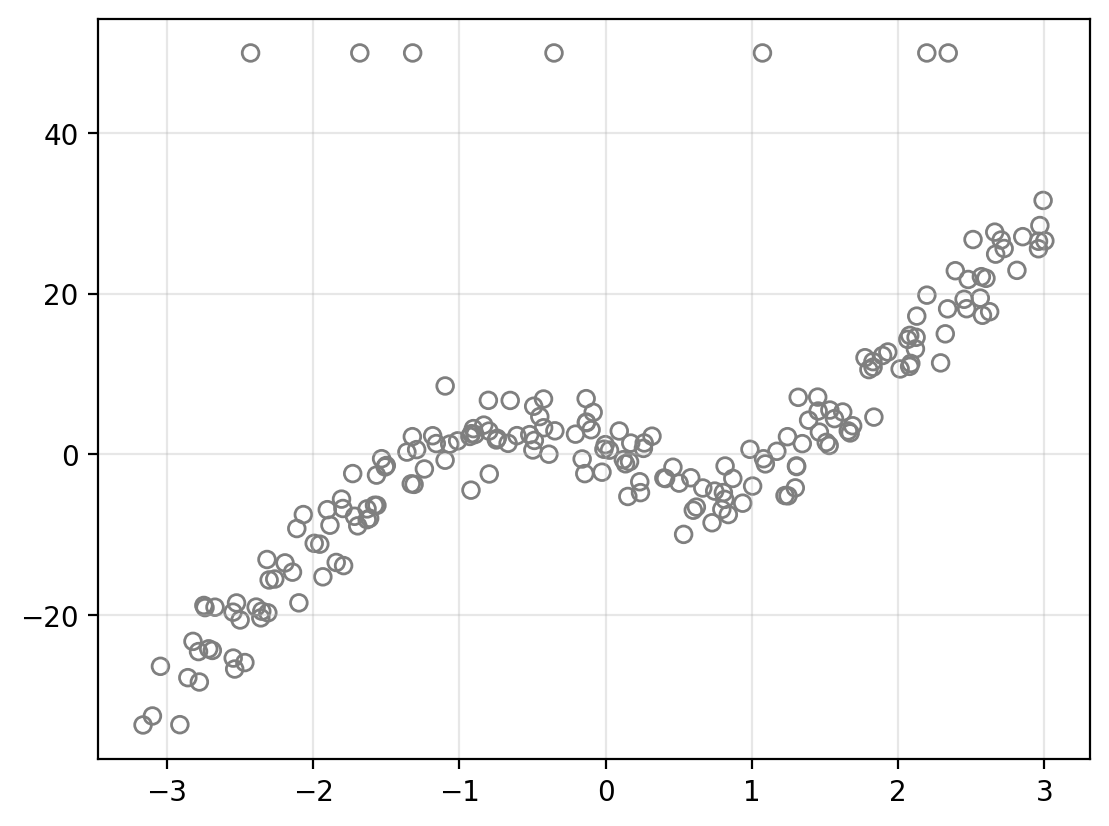

In [235]:
key = jax.random.PRNGKey(31415)
key_train, key_sample_obs, key_eval = jax.random.split(key, 3)

n_obs = 200
xmin, xmax = -3, 3
sigma_y = 3.0
x, y = sample_observations_one_sided(key_sample_obs, f, n_obs, xmin, xmax, x_noise=0.1, y_noise=sigma_y)
xtest = jnp.linspace(x.min(), x.max(), n_obs)
plt.scatter(x, y, edgecolors="tab:gray", color="none")
plt.grid(alpha=0.3)


In [236]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x
model = MLP()
params_init = model.init(key_train, x[:, None])


In [237]:
def latent_fn(x): return x

### Extended Kalman Filter

In [275]:
agent_ekf = gf.ExtendedKalmanFilter(
    latent_fn, model.apply, dynamics_covariance=1e-3, observation_covariance=1.0 * jnp.eye(1)
    
)

bel_init = agent_ekf.init_bel(params_init, cov=1.0)
bel_ekf, hist_bel_ekf = agent_ekf.scan(bel_init, y, x[:, None], callbacks.get_updated_bel)
yhat_ekf = agent_ekf.vobs_fn(bel_ekf.mean, xtest[:, None]).ravel()

### Robust Extended Kalman Filter

In [305]:
agent_rekf = rfilter.ExtendedRobustKalmanFilter(
    latent_fn, model.apply, dynamics_covariance=1e-4, prior_observation_covariance=1.0 * jnp.eye(1),
    noise_scaling=1.0,
    n_inner=1
)

bel_init = agent_rekf.init_bel(params_init, cov=1.0)
bel_rekf, hist_bel_rekf = agent_rekf.scan(bel_init, y, x[:, None], callbacks.get_updated_bel)
yhat_rekf = agent_rekf.vobs_fn(bel_rekf.mean, xtest[:, None]).ravel()

### Inverse Multi-quadratic filter

In [341]:
agent_imq = gbfilter.IMQFilter(
    model.apply, dynamics_covariance=1e-4, observation_covariance=1.0,
    soft_threshold=3.0
)

bel_init = agent_imq.init_bel(params_init, cov=1.0)
bel_imq, hist_bel_imq = agent_imq.scan(bel_init, y, x[:, None], callbacks.get_updated_bel)
yhat_imq = agent_imq.link_fn(bel_imq.mean, xtest[:, None]).ravel()

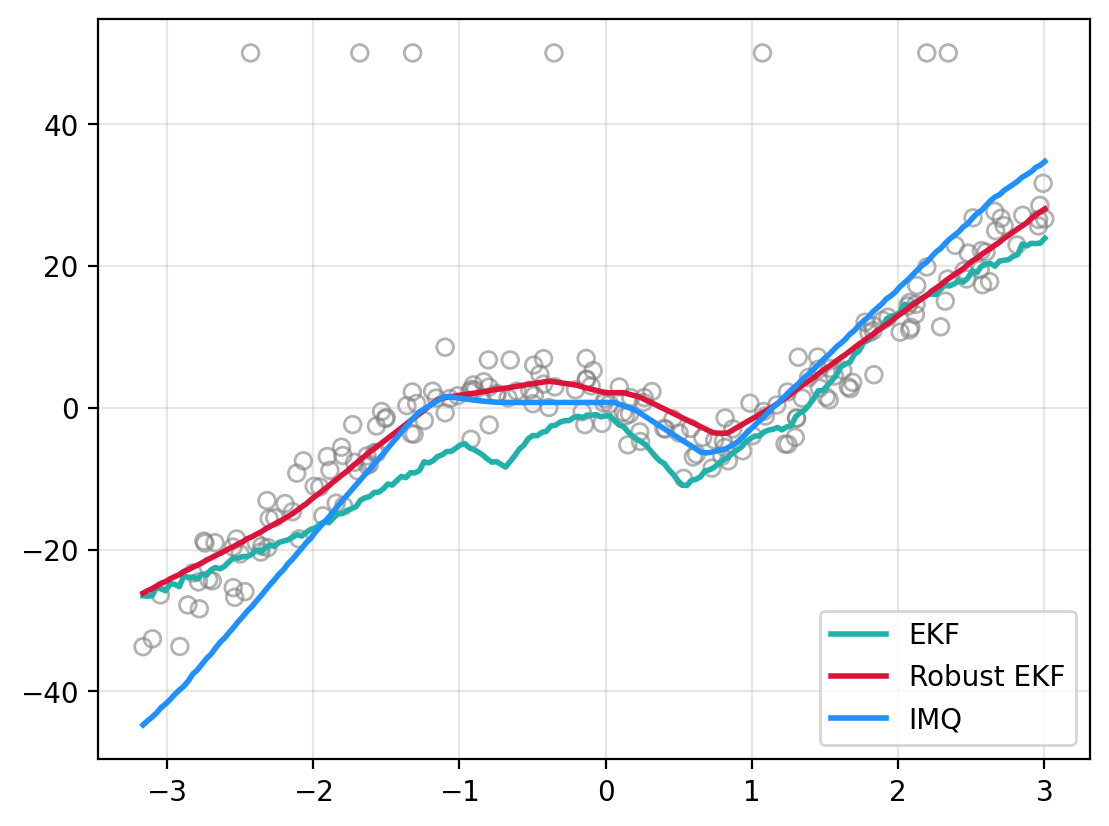

In [342]:
plt.scatter(x, y, edgecolors="tab:gray", c="none", alpha=0.6)
plt.plot(xtest, yhat_ekf, c="lightseagreen", linewidth=2, label="EKF")
plt.plot(xtest, yhat_rekf, c="crimson", linewidth=2, label="Robust EKF")
plt.plot(xtest, yhat_imq, c="dodgerblue", linewidth=2, label="IMQ")
plt.grid(alpha=0.3)
plt.legend()

## Multiple runs

In [343]:
ytest = f(xtest)

In [344]:
from functools import partial

In [345]:
import numpy as np
import pandas as pd
import seaborn as sns

In [346]:
@partial(jax.vmap)
@jax.jit
def sample_and_eval(key):
    key_train, key_sample_obs, key_eval = jax.random.split(key, 3)
    x, y = sample_observations_one_sided(key_sample_obs, f, n_obs, xmin, xmax, x_noise=0.1, y_noise=sigma_y)
    
    bel_init = agent_rekf.init_bel(params_init, cov=1.0)
    bel_rekf, _ = agent_rekf.scan(bel_init, y, x[:, None])
    yhat_rekf = agent_rekf.vobs_fn(bel_rekf.mean, xtest[:, None]).ravel()

    bel_init = agent_imq.init_bel(params_init, cov=1.0)
    bel_imq, _ = agent_imq.scan(bel_init, y, x[:, None])
    yhat_imq = agent_imq.link_fn(bel_imq.mean, xtest[:, None]).ravel()

    errs = {
        "rekf": jnp.power(yhat_rekf - ytest, 2).mean(),
        "imqf": jnp.power(yhat_imq - ytest, 2).mean()
    }
    
    return errs

In [347]:
%%time
n_sims = 100
key = jax.random.PRNGKey(314)
keys = jax.random.split(key, n_sims)
results = sample_and_eval(keys)
results = jax.tree_map(np.array, results)
results_df = pd.DataFrame(results)

CPU times: user 26 s, sys: 585 ms, total: 26.6 s
Wall time: 18.2 s


In [348]:
results_df.describe()

,imqf,rekf
count,100.000000,1.000000e+02
mean,5395.240234,1.452838e+04
std,53744.253906,1.450000e+05
min,1.028355,1.136708e+00
25%,2.532598,2.994126e+00
50%,4.596254,5.239744e+00
75%,8.740983,7.699739e+00
max,537463.187500,1.450028e+06


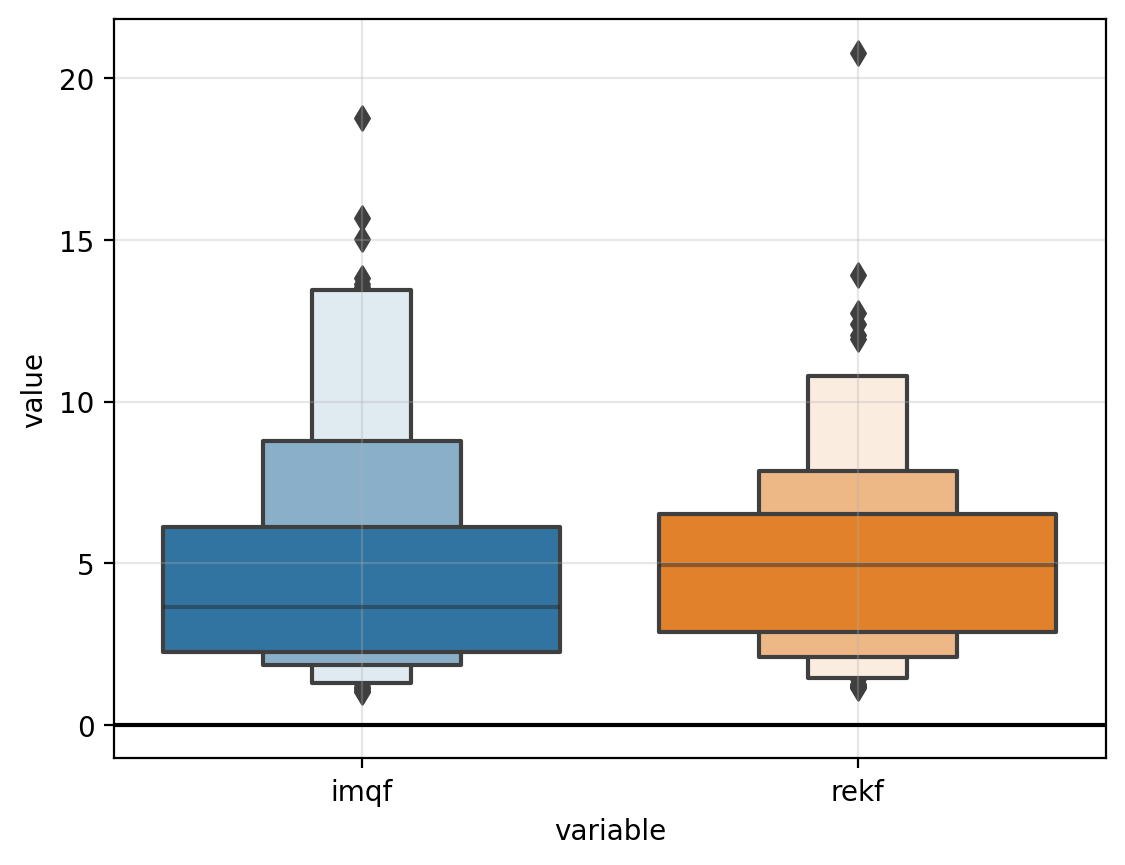

In [349]:
sns.boxenplot(
    results_df.melt().query("value < 30"),
    x="variable", y="value"
)
plt.grid(alpha=0.3)
plt.axhline(y=0, c="black")